In [68]:
import pyreadr
import numpy as np
import os
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import wget
import shutil


In [105]:
#Sets home directory (input yours)
home_dir = 'C:/Users/wasab/Documents/Copy of Spectre Files/Documents/SURE Internship'
os.chdir(home_dir)
print(os.getcwd())

C:\Users\wasab\Documents\Copy of Spectre Files\Documents\SURE Internship


In [115]:
#Makes folder for the data, and deletes any previous one to remove old data
shutil.rmtree(home_dir + '/Defra Auto Obtaining', ignore_errors=True)
os.makedirs('Defra Auto Obtaining', exist_ok=True)
os.chdir(home_dir + '/Defra Auto Obtaining')


# Obtaining the data
Credit for the initial code downloading comes from "https://gist.github.com/psychemedia/ad30077359ab1f19fbfcace5236c55c2#file-defra-aur-data-downloader-ipynb"


In [69]:
#This code gets the meta data for all the possible sites to download from, and shows a preview of the dataframe
metadata_link='http://uk-air.defra.gov.uk/openair/R_data/AURN_metadata.RData'
package_url_base = 'https://uk-air.defra.gov.uk/openair/R_data/{fn}'

fn = metadata_url.split('/')[-1]
print(fn)

url = package_url_base.format(fn=fn)

#This automatically downloads the metadata from the supplied url
wget.download(metadata_url)

#Using this, it is possible to read off the site ID for Leicester. 
#If other sites are required, the easiest way is to manually open AURN_metadata.csv in Excel and search for the desired site
pd.set_option('display.max_rows', 500)

metadata_df = pyreadr.read_r(fn)['AURN_metadata']['Parameter_name'][1322:1357]
metadata_df.to_csv(fn + '.csv', encoding='utf-8', index=False)
print(pyreadr.read_r(fn)['AURN_metadata'][1322:1397])

AURN_metadata.RData
100% [..............................................................................] 32002 / 32002         site_id                         site_name        location_type  \
rownames                                                                  
1323         LDS                Leeds Potternewton     Urban Background   
1324         LDS                Leeds Potternewton     Urban Background   
1325         LDS                Leeds Potternewton     Urban Background   
1326         LDS                Leeds Potternewton     Urban Background   
1327         LDS                Leeds Potternewton     Urban Background   
1328         LDS                Leeds Potternewton     Urban Background   
1329        LEIR           Leicester A594 Roadside        Urban Traffic   
1330        LEIR           Leicester A594 Roadside        Urban Traffic   
1331        LEIR           Leicester A594 Roadside        Urban Traffic   
1332        LEIR           Leicester A594 Roadside      

In [117]:
#Set desired site and year
site = 'LECU'
year = 2022

fn = '{site}_{year}.RData'.format(site=site.upper(), year=year)

url = package_url_base.format(fn=fn)
wget.download(url)

#Read the data
lecu_data = list(pyreadr.read_r(fn).keys())[0]
pyreadr.read_r(fn)[lecu_data].to_csv(lecu_data + '.csv', encoding='utf-8', index=False)


100% [............................................................................] 295853 / 295853

# Making and plotting the basic variables in the dataset

                           O3       NO      NO2  NOXasNO2    PM10  PM2.5  \
date                                                                       
2022-01-01 00:00:00  51.82168  0.28394  3.53703   3.97240  10.375  8.396   
2022-01-01 01:00:00  47.63071  0.24338  2.54406   2.91723   6.950  5.755   
2022-01-01 02:00:00  46.30024  0.24338  2.97854   3.35171   7.950  6.109   
2022-01-01 03:00:00  45.80132  0.18253  3.72355   4.00343  10.050  7.453   
2022-01-01 04:00:00  46.40003  0.27380  2.18706   2.60689  11.400  8.420   
...                       ...      ...      ...       ...     ...    ...   
2022-09-01 19:00:00  73.64133  0.87311  7.07625   8.41500  11.400  4.528   
2022-09-01 20:00:00  74.43961  0.49892  5.35500   6.12000  11.800  4.906   
2022-09-01 21:00:00  72.64348  0.24946  5.54625   5.92875     NaN  5.300   
2022-09-01 22:00:00  73.24219  0.24946  5.16375   5.54625  11.300  5.200   
2022-09-01 23:00:00  72.84305  0.24946  4.97250   5.35500  12.000  5.100   

           

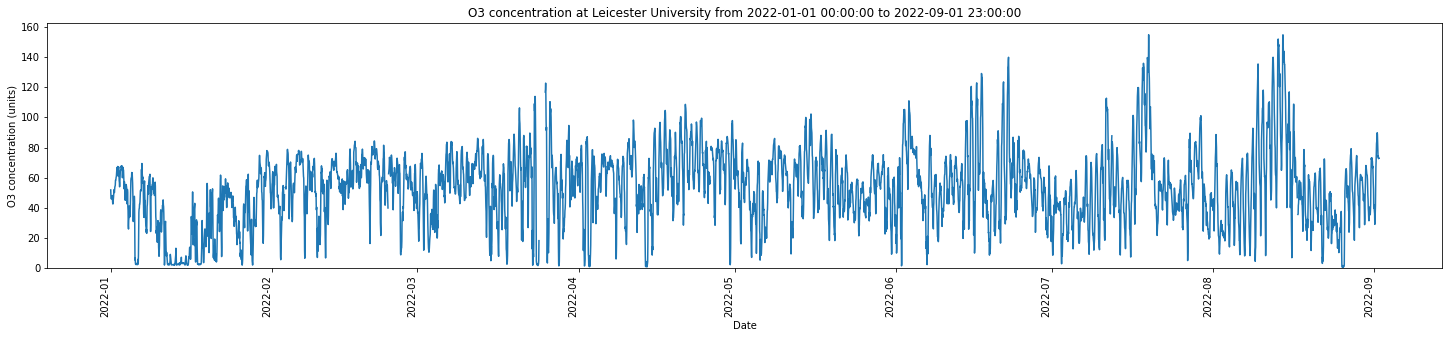

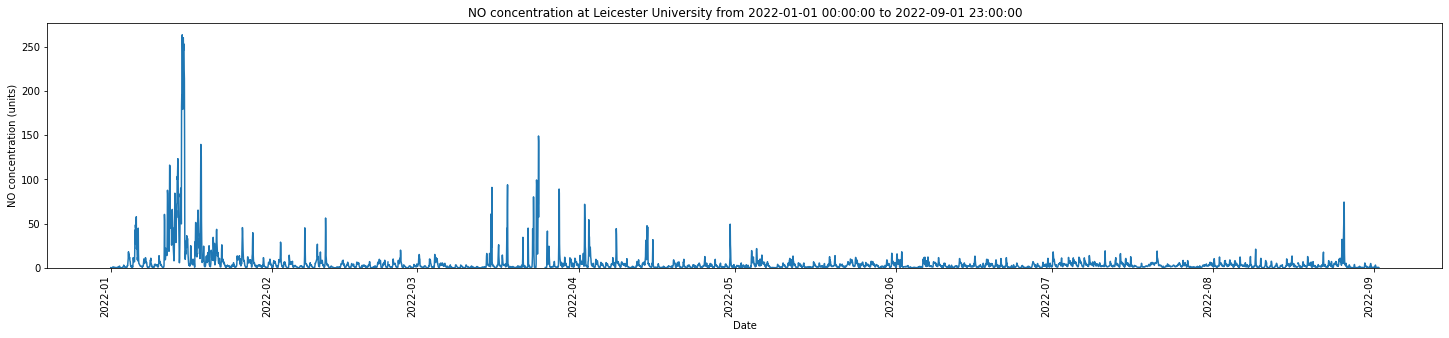

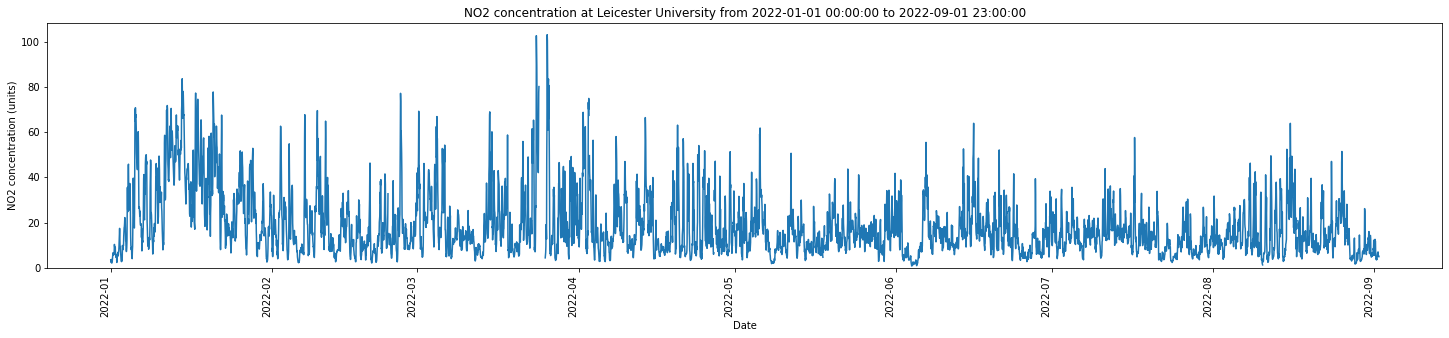

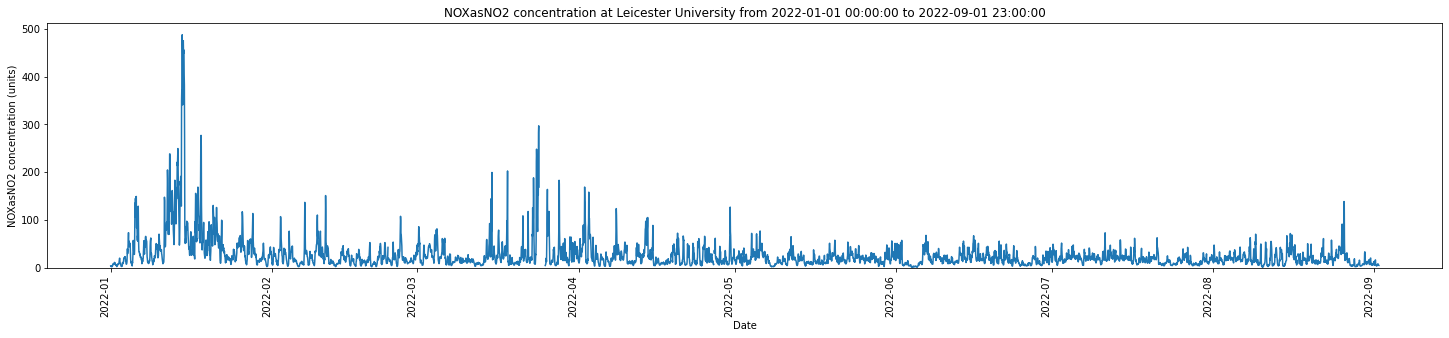

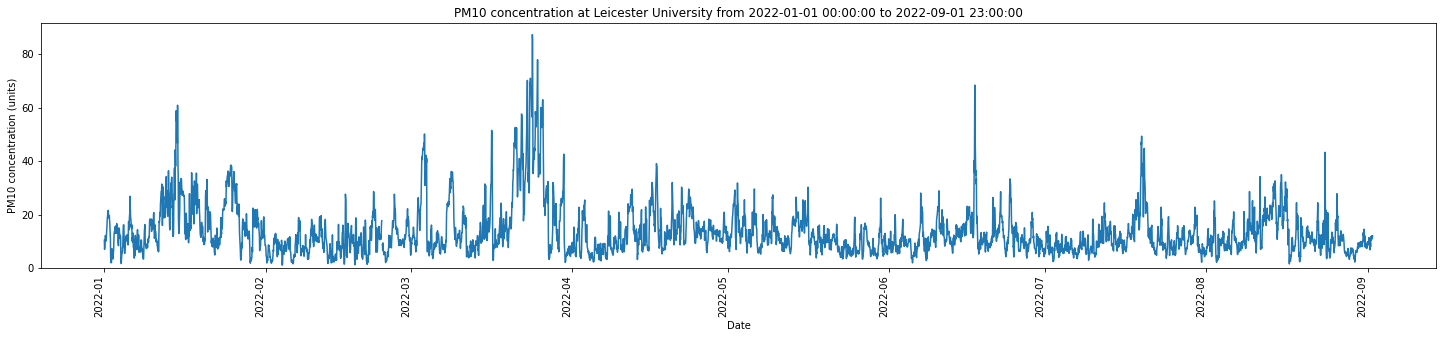

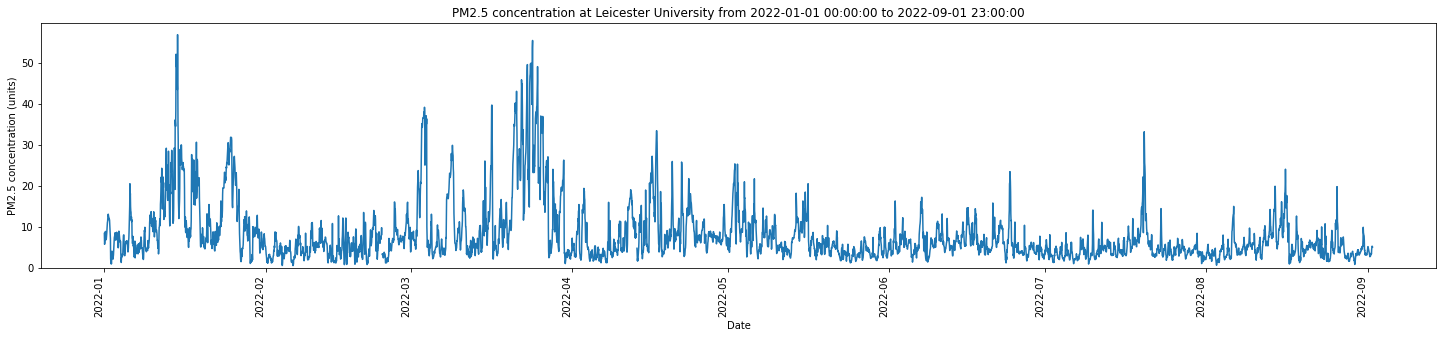

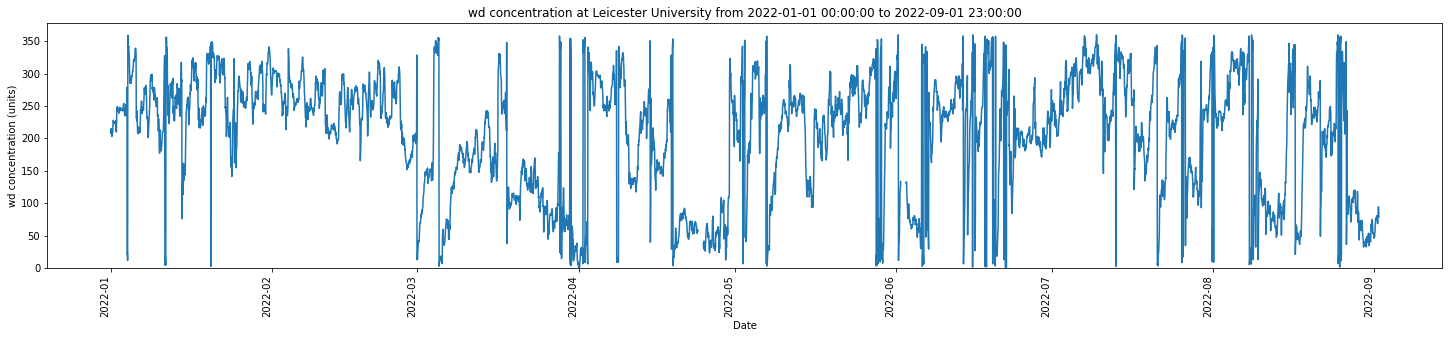

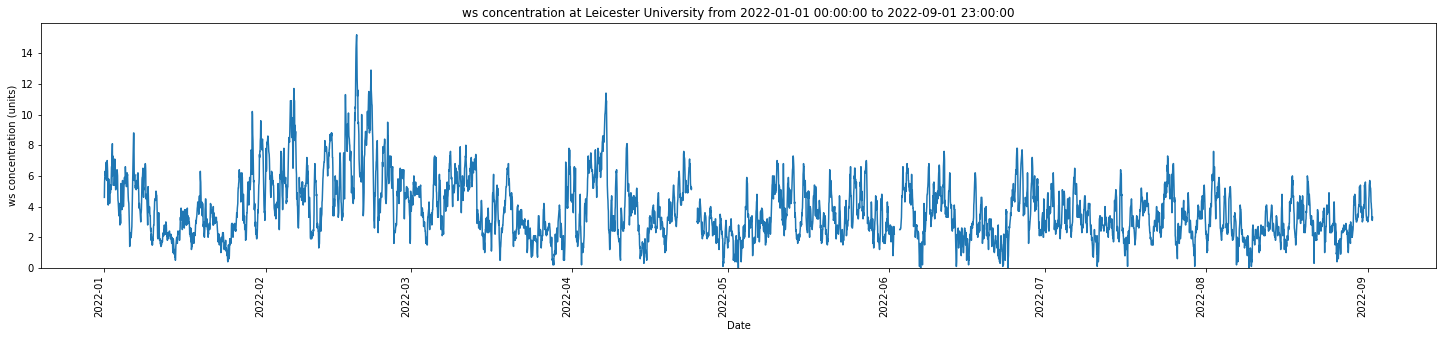

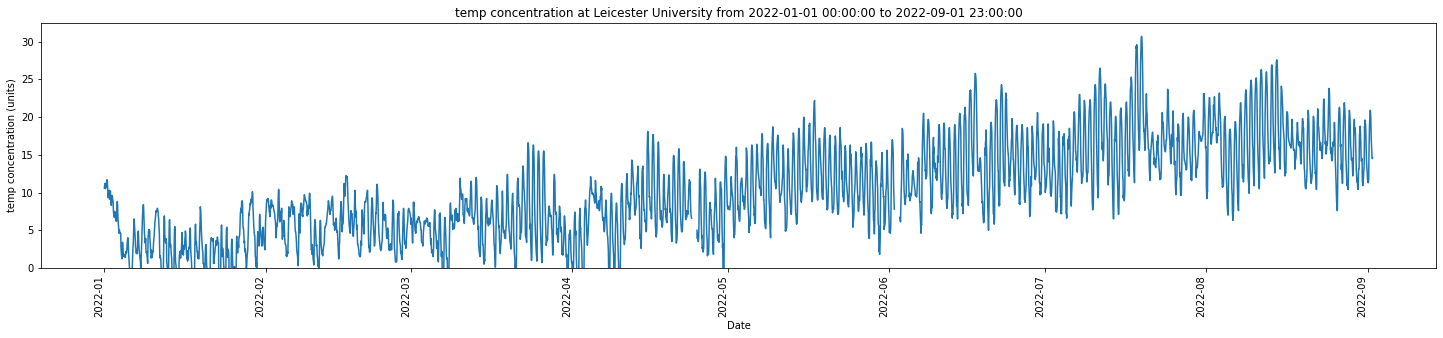

In [120]:
fn = '{site}_{year}.RData'.format(site=site.upper(), year=year)
#Create a dataframe from the data
df_main = pyreadr.read_r(fn)

#Set the dataframe index and drop the original table
df = df_main['LECU_2022']
df = df.set_index(df['date'])
df.drop('date', inplace=True, axis=1)

print(df)

#Plot each column in the dataframe
for i in df.keys()[:-2]:
    Site_Name = df['site'].values[0];
    Start_Date = df.index[0]
    End_Date = df.index[-1]
    df.plot(y = i, x_compat = True, rot = 90, figsize = (25, 5),
        legend = False, xlabel = "Date", 
        title = str(i) + ' concentration at ' + str(Site_Name) + ' from ' + str(Start_Date) + ' to ' + str(End_Date), 
        ylabel = str(i) + ' concentration (units)', ylim=(0))


# Making the basic Air Quality Index (AQI) dataframe

In [138]:
aqi_df = pd.DataFrame(df_main['LECU_2022']['date'])

aqi_list = 'LECU_2022'

#Input desired pollutant names and add them to the dataframe
pollutants = 'O3', 'NO2', 'PM10', 'PM2.5'
for i in pollutants:
    aqi_df[i] = df_main[aqi_list][i]

#Set the dataframe index
aqi_df = aqi_df.set_index(aqi_df['date'])
aqi_df.drop('date', inplace=True, axis=1)

#Create rolling means depending on the time average needed for each specific pollutant
for i in ['PM10', 'PM2.5']:
    label = str(i) + '_24hr_avg'
    aqi_df[label] = aqi_df[i].rolling(window = 24, min_periods = 16).mean().values

for i in ['O3']:
    label = str(i) + '_8hr_avg'
    aqi_df[label] = aqi_df[i].rolling(window = 8, min_periods = 1).mean().values

In [139]:
aqi_df

,O3,NO2,PM10,PM2.5,PM10_24hr_avg,PM2.5_24hr_avg,O3_8hr_avg
date,,,,,,,
2022-01-01 00:00:00,51.82168,3.53703,10.375,8.396,NaN,NaN,51.821680
2022-01-01 01:00:00,47.63071,2.54406,6.950,5.755,NaN,NaN,49.726195
2022-01-01 02:00:00,46.30024,2.97854,7.950,6.109,NaN,NaN,48.584210
2022-01-01 03:00:00,45.80132,3.72355,10.050,7.453,NaN,NaN,47.888487
2022-01-01 04:00:00,46.40003,2.18706,11.400,8.420,NaN,NaN,47.590796
...,...,...,...,...,...,...,...
2022-09-01 19:00:00,73.64133,7.07625,11.400,4.528,9.454167,3.785500,83.320475
2022-09-01 20:00:00,74.43961,5.35500,11.800,4.906,9.595833,3.860208,82.297679
2022-09-01 21:00:00,72.64348,5.54625,NaN,5.300,9.652174,3.935583,80.900689


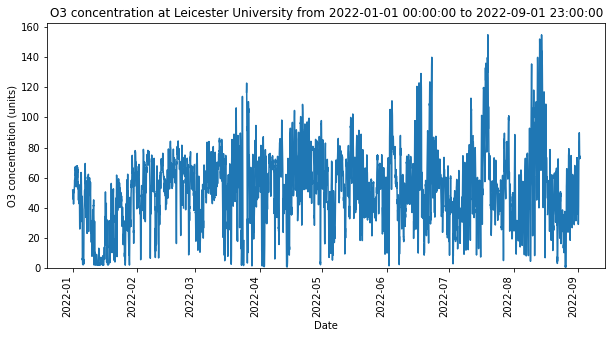

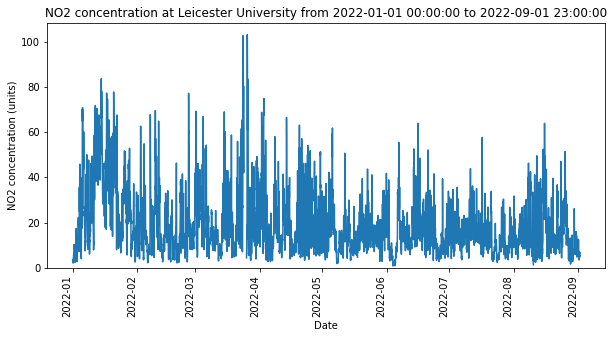

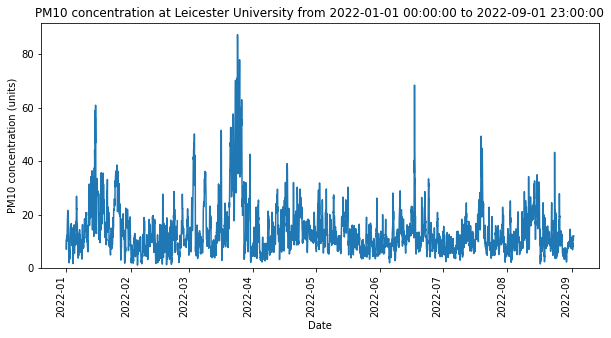

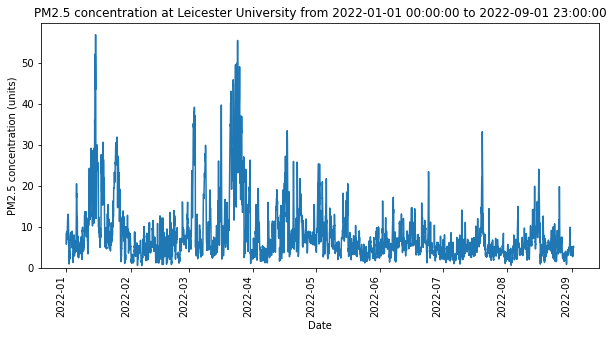

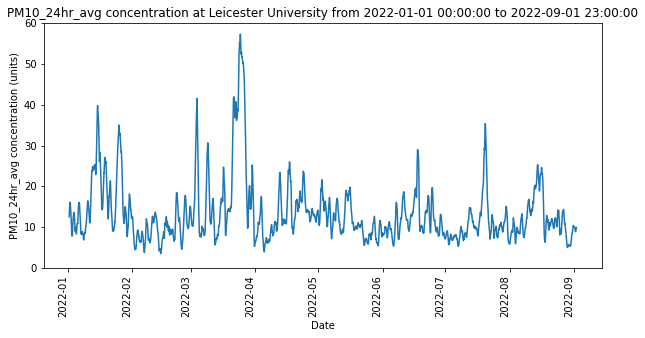

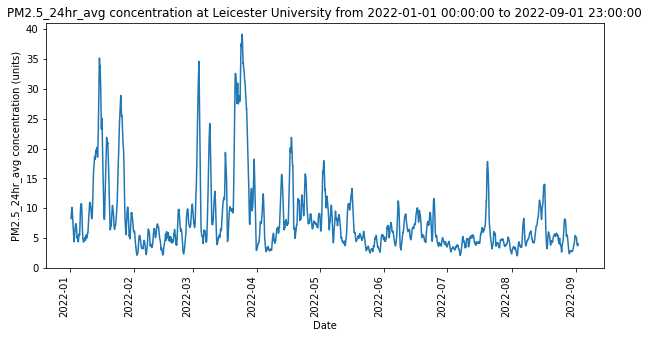

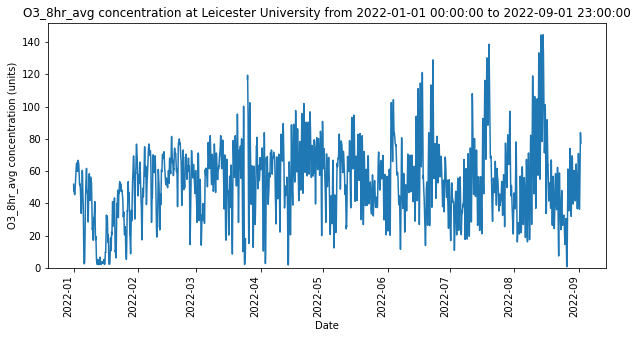

In [140]:
#Plot all the pollutants and their rolling means
for i in aqi_df.keys():
    Site_Name = df['site'].values[0];
    Start_Date = df.index[0]
    End_Date = df.index[-1]
    aqi_df.plot(y = i, x_compat = True, rot = 90, figsize = (10, 5),
        legend = False, xlabel = "Date", 
        title = str(i) + ' concentration at ' + str(Site_Name) + ' from ' + str(Start_Date) + ' to ' + str(End_Date), 
        ylabel = str(i) + ' concentration (units)', ylim=(0))



# Create AQI list for each of the desired pollutants
Each if statement is indicative of each banding for the specific pollutant. Please improve this if you come up with a more consise method <3

In [141]:
def get_PM10_subindex(x):
    if x <= 16:
        return 1
    elif x <= 33:
        return 2
    elif x <= 50:
        return 3
    elif x <= 58:
        return 4
    elif x <= 66:
        return 5
    elif x <= 75:
        return 6
    elif x <= 83:
        return 7
    elif x <= 91:
        return 8
    elif x <= 100:
        return 9
    elif x > 101:
        return 10
    else:
        return np.nan

aqi_df["PM10_SubIndex"] = aqi_df["PM10_24hr_avg"].apply(lambda x: get_PM10_subindex(x))

In [142]:
def get_PM2_5_subindex(x):
    if x <= 11:
        return 1
    elif x <= 23:
        return 2
    elif x <= 35:
        return 3
    elif x <= 41:
        return 4
    elif x <= 47:
        return 5
    elif x <= 53:
        return 6
    elif x <= 58:
        return 7
    elif x <= 64:
        return 8
    elif x <= 70:
        return 9
    elif x > 71:
        return 10
    else:
        return np.nan

aqi_df["PM2.5_SubIndex"] = aqi_df["PM2.5_24hr_avg"].apply(lambda x: get_PM2_5_subindex(x))

In [143]:
def get_NO2_subindex(x):
    if x <= 67:
        return 1
    elif x <= 134:
        return 2
    elif x <= 200:
        return 3
    elif x <= 267:
        return 4
    elif x <= 334:
        return 5
    elif x <= 400:
        return 6
    elif x <= 467:
        return 7
    elif x <= 534:
        return 8
    elif x <= 600:
        return 9
    elif x > 600:
        return 10
    else:
        return np.nan

aqi_df["NO2_SubIndex"] = aqi_df["NO2"].apply(lambda x: get_NO2_subindex(x))

In [144]:
def get_O3_subindex(x):
    if x <= 33:
        return 1
    elif x <= 66:
        return 2
    elif x <= 100:
        return 3
    elif x <= 120:
        return 4
    elif x <= 140:
        return 5
    elif x <= 160:
        return 6
    elif x <= 187:
        return 7
    elif x <= 213:
        return 8
    elif x <= 240:
        return 9
    elif x > 241:
        return 10
    else:
        return np.nan

aqi_df["O3_SubIndex"] = aqi_df["O3_8hr_avg"].apply(lambda x: get_O3_subindex(x))

['O3_SubIndex', 'NO2_SubIndex', 'PM10_SubIndex', 'PM2.5_SubIndex']


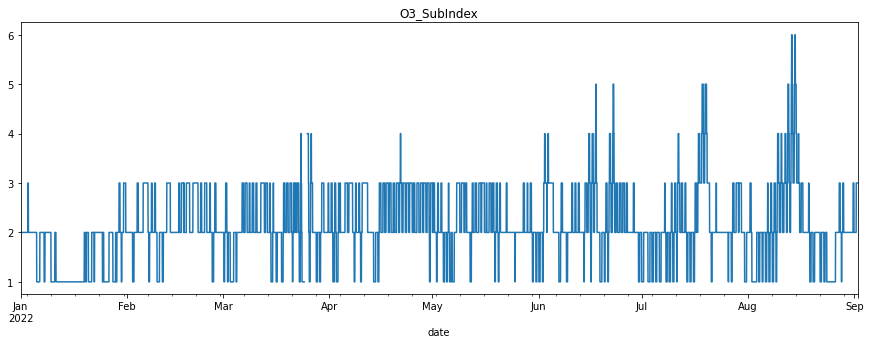

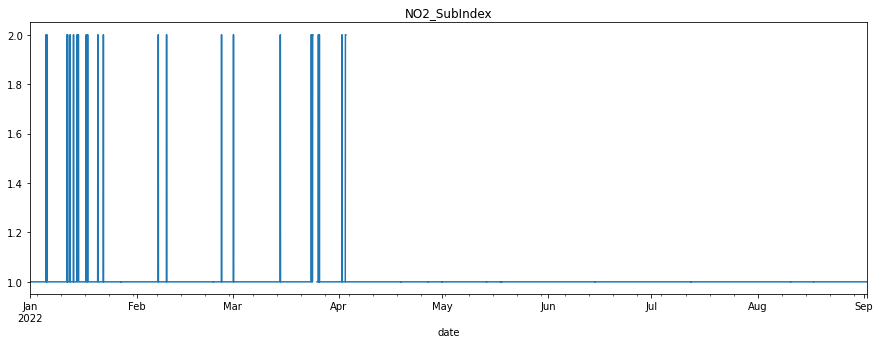

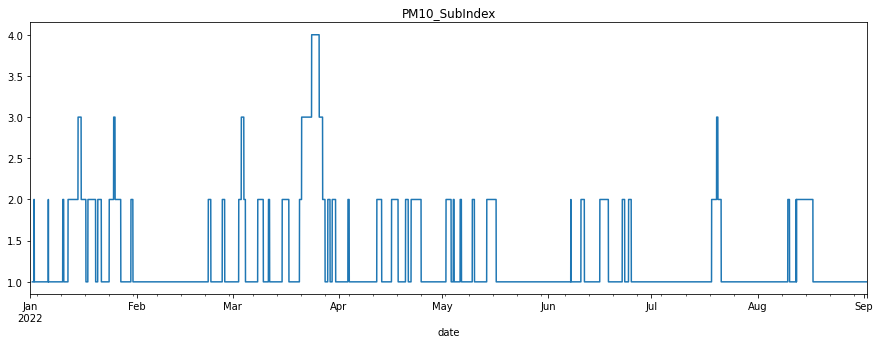

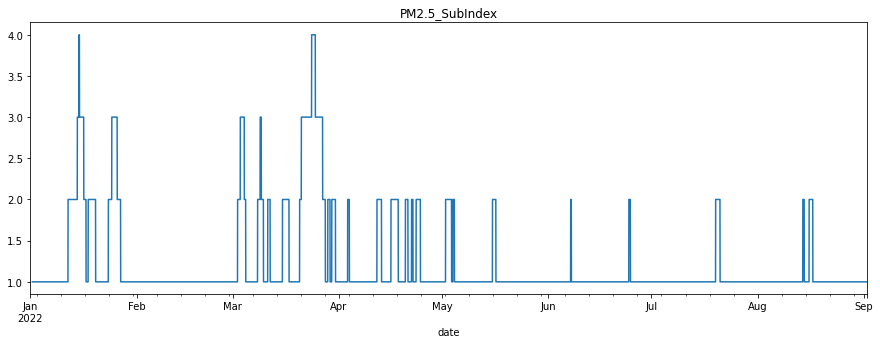

In [145]:
#Indicate that each of these new plots are subindexes
pollutant_SubIndex = []
for i in pollutants:
    pollutant_SubIndex.append(str(i) + '_SubIndex')
    
print(pollutant_SubIndex)
for i in pollutant_SubIndex:
    aqi_df.plot(y = i, legend = False, figsize = (15,5), title = i)

In [146]:
#Print new and improved AQI dataframe
aqi_df

,O3,NO2,PM10,PM2.5,PM10_24hr_avg,PM2.5_24hr_avg,O3_8hr_avg,PM10_SubIndex,PM2.5_SubIndex,NO2_SubIndex,O3_SubIndex
date,,,,,,,,,,,
2022-01-01 00:00:00,51.82168,3.53703,10.375,8.396,NaN,NaN,51.821680,NaN,NaN,1.0,2.0
2022-01-01 01:00:00,47.63071,2.54406,6.950,5.755,NaN,NaN,49.726195,NaN,NaN,1.0,2.0
2022-01-01 02:00:00,46.30024,2.97854,7.950,6.109,NaN,NaN,48.584210,NaN,NaN,1.0,2.0
2022-01-01 03:00:00,45.80132,3.72355,10.050,7.453,NaN,NaN,47.888487,NaN,NaN,1.0,2.0
2022-01-01 04:00:00,46.40003,2.18706,11.400,8.420,NaN,NaN,47.590796,NaN,NaN,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01 19:00:00,73.64133,7.07625,11.400,4.528,9.454167,3.785500,83.320475,1.0,1.0,1.0,3.0
2022-09-01 20:00:00,74.43961,5.35500,11.800,4.906,9.595833,3.860208,82.297679,1.0,1.0,1.0,3.0
2022-09-01 21:00:00,72.64348,5.54625,NaN,5.300,9.652174,3.935583,80.900689,1.0,1.0,1.0,3.0


In [147]:
#Convert this dataframe to a .csv
aqi_df.to_csv('aqi_df' + '.csv', encoding='utf-8', index=False)

In [148]:
#Average each AQI banding to obtain the main AQI banding (while ignoring NaNs)
aqi_index = []
for i in aqi_df.index:
    aqi_index.append(np.nanmean([aqi_df['PM10_SubIndex'][i], aqi_df['PM2.5_SubIndex'][i], aqi_df['NO2_SubIndex'][i], aqi_df['O3_SubIndex'][i]]))

#Add to main dataframe
aqi_df['aqi_index'] = aqi_index

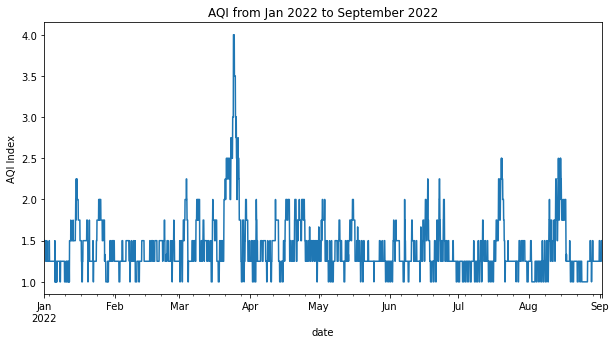

In [149]:
#Plot the main AQI
aqi_df.plot(y = 'aqi_index', legend = False, figsize = (10,5), title = 'AQI from Jan 2022 to September 2022', ylabel = 'AQI Index')